In [8]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from torchvision import transforms
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Function to convert image to graph
def image_to_graph(image_path, patch_size=8):
    img = Image.open(image_path).convert('RGB')
    img = img.resize((64, 64))  # Resize to fixed size
    img_array = np.array(img)
    h, w, c = img_array.shape
    
    # Divide into patches
    patches = []
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = img_array[i:i+patch_size, j:j+patch_size].flatten()
            patches.append(patch)
    
    num_patches = len(patches)
    node_features = torch.tensor(np.array(patches), dtype=torch.float)
    
    # Create edges for grid adjacency
    edges = []
    grid_size = int(np.sqrt(num_patches))
    for i in range(grid_size):
        for j in range(grid_size):
            idx = i * grid_size + j
            # Right
            if j + 1 < grid_size:
                edges.append([idx, idx + 1])
                edges.append([idx + 1, idx])
            # Down
            if i + 1 < grid_size:
                edges.append([idx, idx + grid_size])
                edges.append([idx + grid_size, idx])
    
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    
    return Data(x=node_features, edge_index=edge_index)

In [3]:
# Custom Dataset class
class KakaoDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels):
        self.image_paths = image_paths
        self.labels = labels
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        graph = image_to_graph(self.image_paths[idx])
        graph.y = torch.tensor(self.labels[idx], dtype=torch.long)
        return graph

In [4]:
# Load data
sehat_paths = [os.path.join('Sehat', f) for f in os.listdir('Sehat') if f.endswith('.jpg')]
vsd_paths = [os.path.join('VSD', f) for f in os.listdir('VSD') if f.endswith('.jpg')]
all_paths = sehat_paths + vsd_paths
labels = [0] * len(sehat_paths) + [1] * len(vsd_paths)

# Train-val split
train_paths, val_paths, train_labels, val_labels = train_test_split(all_paths, labels, test_size=0.2, random_state=42)

train_dataset = KakaoDataset(train_paths, train_labels)
val_dataset = KakaoDataset(val_paths, val_labels)

In [5]:
# Define GNN model
class GNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = global_mean_pool(x, batch)  # Global mean pooling per graph in batch
        x = self.fc(x)
        return x

In [6]:
# Prepare DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Model, optimizer, loss
model = GNNModel(input_dim=8*8*3, hidden_dim=64, output_dim=2)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

c:\Users\Ariful\anaconda3\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
# Training loop
num_epochs = 10
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        outputs = model(batch)
        loss = criterion(outputs, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f'Epoch {epoch+1}, Loss: {avg_loss}')

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in val_loader:
            outputs = model(batch)
            _, predicted = torch.max(outputs.data, 1)
            total += batch.y.size(0)
            correct += (predicted == batch.y).sum().item()
    accuracy = 100 * correct / total
    val_accuracies.append(accuracy)
    print(f'Validation Accuracy: {accuracy}%')



Epoch 1, Loss: 2.363898195681118
Validation Accuracy: 90.8%
Epoch 2, Loss: 0.42499569507818374
Validation Accuracy: 91.2%
Epoch 3, Loss: 0.48262484838801717
Validation Accuracy: 91.2%
Epoch 4, Loss: 0.48261208767219194
Validation Accuracy: 92.4%
Epoch 5, Loss: 0.32929567998600384
Validation Accuracy: 87.2%


NameError: name 'plt' is not defined

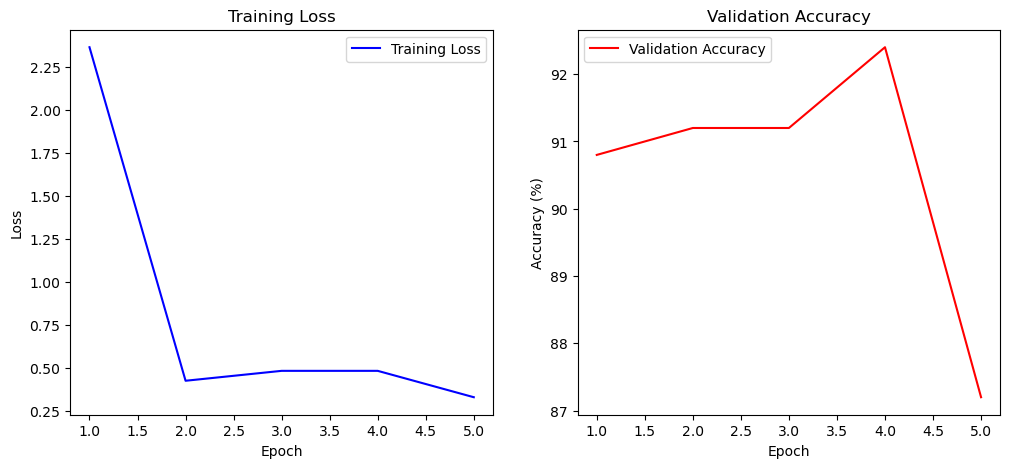

In [9]:
# Plot training loss and validation accuracy
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()